# ДЗ-2 по Теории и практике онлайн экспериментов

### Задание 1 (1.5 балла)

В приложенном файле `sleep.csv` приведено время засыпания одного и того же человека в разные дни.

Нужно обработать эти данные и указать такое время суток (с точностью до минуты), после которого с вероятностью 0.9 этот человек уже спит.

Как можно оценить стандартное отклонение этой точечной оценки?

In [1]:
# !pip install gdown

In [2]:
import pandas as pd
import requests
from io import StringIO

# Прямая ссылка на скачивание файла
url = 'https://drive.google.com/uc?id=1EhaU8BcM9vxkVkmOycolype77B1yzEPr'

# Загрузка файла
response = requests.get(url)

# Преобразование данных в строку
data = response.text

# Чтение данных CSV
df = pd.read_csv(StringIO(data))

In [3]:
df.head()

,Unnamed: 0,indicator,time_offset
0,2017-12-01 21:00:00,0,-60
1,2017-12-01 21:01:00,0,-59
2,2017-12-01 21:02:00,0,-58
3,2017-12-01 21:03:00,0,-57
4,2017-12-01 21:04:00,0,-56


In [4]:
df_sorted = df.sort_values(by='time_offset') # отсортируем по возрастанию

In [5]:
df_sorted.head()

,Unnamed: 0,indicator,time_offset
0,2017-12-01 21:00:00,0,-60
4320,2017-12-25 21:00:00,0,-60
1260,2017-12-08 21:00:00,0,-60
10080,2018-01-26 21:00:00,0,-60
6840,2018-01-08 21:00:00,0,-60


Мы видим, что у нас в таблице в столбце `indicator` указаны значения, когда человек спит и когда не спит, в столбце `time_offset` указаны значения в минутах в расчете от 22:00:00. Поскольку нам надо найти время суток в минутах, после которого человек с вероятностью 0,9 будет спать, то будем искать квантиль 0,9 случайной величины "человек спит". Для этого оставим столбец только, где человек спит (соответствует $indicator==1$), отсортируем наблюдения в порядке возрастания и найдем квантиль отранжированного ряда, полученное число - это время суток, после которого человек с вероятностью 0,9 будет спать (иначе говоря, 90% наблюдений, когда человек спит будут лежать левее этого значения). В конце просто переведем это значение в сутки. Оценку стандартного отклонения найдем с помощью бутстрапа.

In [6]:
import numpy as np

sleep = df[df['indicator'] == 1]['time_offset']  # оставим только таблицу с заснувшими людьми

n = len(sleep)            # размер исходной выборки
B = n            # количество генерируемых подвыборок

quantile = np.quantile(sleep, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(sleep, n, True)
    bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))
std = np.std(bootstrap_quantiles)
print(f'Оценка 90% квантиля: {quantile:0.2f}')
print(f'Оценка std для 90% квантиля: {std:0.2f}')

Оценка 90% квантиля: 109.00
Оценка std для 90% квантиля: 0.45


### 109 минут соответствует времени **23:49:00**. Стандартное отклонение точечной оценки квантиля $+-$ 0.44 мин примерно.

-----------
Представим, что у нас есть сервис для продажи некоторых товаров (например, мыла). Мы выкатываем новые фичи и проводим тесты, а затем сохраняем логи каждого теста в следующем формате:

- `user_id` - уникальный id посетителя сайта
- `dt` - дата события
- `event` - название события
- `group` - группа, в которую попал пользователь (распределение может происходить на разных этапах воронки для разных тестов - например, при первом посещении или при первом добавлении в корзину)
- `visit_id` - уникальный id визита
- `cart_id` - уникальный id корзины
- amount - текущая сумма корзины
- `num_items` - текущее количество товаров в корзине

### Задание 2 (0.5 балла)

Мы сделали рекомендательную систему, которая после добавления товара в корзину предлагает добавить похожие или комплементарные. Логи проведенного теста сохранены в файле `ab_test_logs.pkl`. Проверьте гипотезу о том, что в тестовой группе для 70% пользователей выросла выручка (revenue per user).

In [7]:
import requests
import pickle

# Прямая ссылка на скачивание файла
url = 'https://drive.google.com/uc?id=1J6RpGua4KoN87wuLhzAUO1j-Ml-rV54S'

# Загрузка файла
response = requests.get(url)

# Чтение данных pickle
df1 = pickle.loads(response.content)

In [8]:
df1.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,3Y6FR5,2024-01-17,first-visited,NaN,NaN,NaN,NaN,NaN
1,6W79RT,2024-01-17,first-visited,NaN,NaN,NaN,NaN,NaN
2,6W79RT,2024-01-17,registered,test,NaN,NaN,NaN,NaN
3,6W79RT,2024-01-17,shop-visit,test,3qzhu3sar2vee6rzssyr,NaN,NaN,NaN
4,6W79RT,2024-01-18,shop-visit,test,siglppuqke79ts5a5r4t,NaN,NaN,NaN


In [9]:
# Если мы совершали покупку (есть две записи cart-add и cart-paid с одинаковым cart_id), то мы считаем это в суммарную выручку, иначе не считаем

In [ ]:
df1_test = df1[df1['group']=='test']
df1_control = df1[df1['group']=='control']

import pandas as pd

def find_check_pairs(data):
    # Отфильтруем данные, чтобы оставить только нужные события
    filtered_data = data[(data['event'] == 'cart-add') | (data['event'] == 'cart-paid')]

    # Создадим DataFrame для хранения пар наблюдений
    pairs_df = pd.DataFrame(columns=['user_id', 'group', 'cart_id', 'cart_paid_id', 'revenue'])

    # Пройдемся по каждому пользователю
    for user_id in filtered_data['user_id'].unique():
        user_data = filtered_data[filtered_data['user_id'] == user_id]
        # Пройдемся по каждому cart_id пользователя
        for cart_id in user_data['cart_id'].unique():
            cart_data = user_data[user_data['cart_id'] == cart_id]
            # Проверим, есть ли у данного cart_id события "cart-add" и "cart-paid"
            if ('cart-add' in cart_data['event'].values) and ('cart-paid' in cart_data['event'].values):
                cart_add_row = cart_data[cart_data['event'] == 'cart-add'].iloc[0]
                cart_paid_row = cart_data[cart_data['event'] == 'cart-paid'].iloc[0]
                # Добавим пару наблюдений в DataFrame
                pairs_df = pairs_df.append({'user_id': user_id,
                                            'group': cart_add_row['group'],
                                            'cart_id': cart_id,
                                            'cart_paid_id': cart_paid_row['visit_id'],
                                            'revenue': cart_add_row['amount']},
                                           ignore_index=True)

    return pairs_df


rev_orders_test = find_check_pairs(df1_test)
rev_orders_control = find_check_pairs(df1_control)

In [11]:
rev_orders_test.head()

,user_id,group,cart_id,cart_paid_id,revenue
0,6W79RT,test,zd6s005p6q,84k1tk4iugavhadkbai7,673.411454
1,6W79RT,test,keqkyd3ay9,sunaisr38ktqvulgs6ns,5055.935244
2,6ZODD2,test,kl2m6tttzu,qg3pn8x6528gnj0fssli,2306.844187
3,8325MF,test,pdp3irhzbb,s8m4p232f906n6m7gxe7,698.153135
4,UVX1O1,test,ikhjkog2iy,sxip6yhdqwupf9j9bpb2,507.701473


Мы получили таблицы для тестовой и контрольной группы, в этих таблицах гарантированно есть пользователи, у которых есть хотя бы одна запись c меткой cart-paid. Теперь добавим к этим пользователям пользователей с нулевой выручкой

In [12]:
df1_test_total = pd.concat([rev_orders_test, df1_test[~df1_test['user_id'].isin(rev_orders_test['user_id'])]])[['user_id', 'group', 'cart_id', 'cart_paid_id', 'revenue']]
df1_control_total = pd.concat([rev_orders_control, df1_control[~df1_control['user_id'].isin(rev_orders_control['user_id'])]])[['user_id', 'group', 'cart_id', 'cart_paid_id', 'revenue']]

In [13]:
df1_test_total.head()

,user_id,group,cart_id,cart_paid_id,revenue
0,6W79RT,test,zd6s005p6q,84k1tk4iugavhadkbai7,673.411454
1,6W79RT,test,keqkyd3ay9,sunaisr38ktqvulgs6ns,5055.935244
2,6ZODD2,test,kl2m6tttzu,qg3pn8x6528gnj0fssli,2306.844187
3,8325MF,test,pdp3irhzbb,s8m4p232f906n6m7gxe7,698.153135
4,UVX1O1,test,ikhjkog2iy,sxip6yhdqwupf9j9bpb2,507.701473


In [14]:
rev_test = df1_test_total.groupby('user_id')['revenue'].sum()
rev_control = df1_control_total.groupby('user_id')['revenue'].sum()

orders_test = df1_test_total.groupby('user_id')['cart_id'].count() # Посчитаем число покупок
orders_control = df1_control_total.groupby('user_id')['cart_id'].count()

In [15]:
rev_test.head()

user_id
009TG0       0.000000
01ZW0R    5853.584375
023T5M       0.000000
029P4I       0.000000
02CI39       0.000000
Name: revenue, dtype: float64

In [16]:
B = 10000
alpha = 0.05

def get_percentile_ci(bootstrap_stats, pe, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

pe = np.quantile(rev_test, 0.7) - np.quantile(rev_control, 0.7)

bootstrap_values_control = np.random.choice(rev_control, (B, len(rev_control)), True) # сгенерируем n примеров размера B (матрицу Bxn).
bootstrap_metrics_control = np.quantile(bootstrap_values_control, 0.7, axis=1) # посчитаем квантиль. Получим n квантилей

bootstrap_values_test = np.random.choice(rev_test, (B, len(rev_test)), True)
bootstrap_metrics_test = np.quantile(bootstrap_values_test, 0.7, axis=1)

bootstrap_stats = bootstrap_metrics_test - bootstrap_metrics_control
ci = get_percentile_ci(bootstrap_stats, pe, alpha)
has_effect = not (ci[0] <= 0 <= ci[1])

print(f'Значение 70% квантиля изменилось на: {pe:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение 70% квантиля изменилось на: 0.00
95.0% доверительный интервал: (0.00, 137.38)
Отличия статистически значимые: False


Видим, что разница точечной оценки между тестовой группой с примененным эффектом и контрольной группой, которая была без рекомендательной системы, нулевая, что говорит о том, что выручка в группе с рекомендательными системами не изменилась, эффекта нет.

Мы  также видим, что доверительный интервал включает ноль, поэтому можно говорить, что различия статистически незначимы на уровне $\alpha$. Нет смысла добавлять рекомендательные системы.

### Задание 3 (1 балл)

Как проверить гипотезу о том, что средний чек в А и Б группе разный? Реализуйте этот алгоритм. Помните, что у одного пользователя может быть много чеков.

##### Для каждого юзера для каждой группы рассчитаем средний чек, чтобы пользователи не были зависимыми. В итоге у нас должна получиться одна метрика на одного пользователя. Поэтому т-тест стьюдента будет применим в таких условиях. Проведем тест на значимость разницы средних чеков в группе А и B.

In [17]:
df1.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,3Y6FR5,2024-01-17,first-visited,NaN,NaN,NaN,NaN,NaN
1,6W79RT,2024-01-17,first-visited,NaN,NaN,NaN,NaN,NaN
2,6W79RT,2024-01-17,registered,test,NaN,NaN,NaN,NaN
3,6W79RT,2024-01-17,shop-visit,test,3qzhu3sar2vee6rzssyr,NaN,NaN,NaN
4,6W79RT,2024-01-18,shop-visit,test,siglppuqke79ts5a5r4t,NaN,NaN,NaN


In [18]:
orders_test = df1_test_total.groupby('user_id')['cart_id'].count() # Посчитаем число покупок
orders_control = df1_control_total.groupby('user_id')['cart_id'].count()

In [19]:
orders_test

user_id
009TG0    0
01ZW0R    1
023T5M    0
029P4I    0
02CI39    0
         ..
ZYS6GU    0
ZYWANO    0
ZZ55D1    1
ZZEVTV    0
ZZOQID    1
Name: cart_id, Length: 3295, dtype: int64

In [20]:
rev_test = df1_test_total.groupby('user_id')['revenue'].sum()
rev_control = df1_control_total.groupby('user_id')['revenue'].sum()

In [21]:
df_merged_test = pd.merge(rev_test, orders_test, on='user_id', how='outer')
df_merged_control = pd.merge(rev_control, orders_control, on='user_id', how='outer')

# # Рассчитайте средний чек для каждого пользователя
df_merged_test['average_order_value'] = df_merged_test['revenue'] / df_merged_test['cart_id']
df_merged_test = df_merged_test.fillna(0, inplace=False)

df_merged_control['average_order_value'] = df_merged_control['revenue'] / df_merged_control['cart_id']
df_merged_control = df_merged_control.fillna(0, inplace=False)

In [22]:
df_merged_test.loc["6W79RT"]

revenue                5729.346699
cart_id                   2.000000
average_order_value    2864.673349
Name: 6W79RT, dtype: float64

In [23]:
average_order_test = df_merged_test['average_order_value']
average_order_control = df_merged_control['average_order_value']

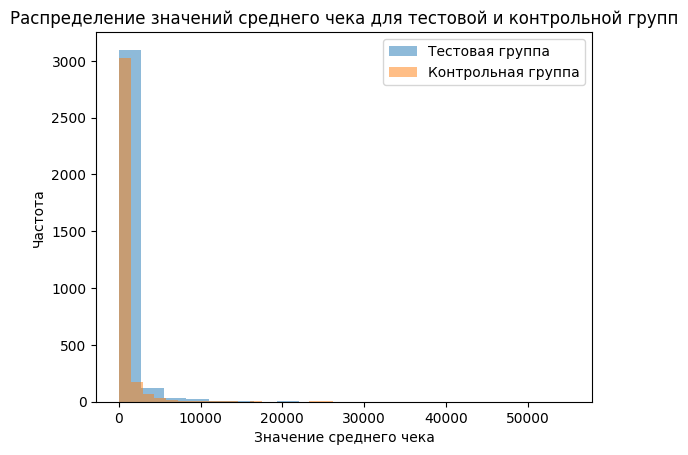

In [24]:
import matplotlib.pyplot as plt
plt.hist(average_order_test, bins=20, alpha=0.5, label='Тестовая группа')
plt.hist(average_order_control, bins=20, alpha=0.5, label='Контрольная группа')
plt.xlabel('Значение среднего чека')
plt.ylabel('Частота')
plt.title('Распределение значений среднего чека для тестовой и контрольной групп')
plt.legend()
plt.show()

Видим, что распределение средних чеков в тестовой и контрольной группах отличаются, поэтому не будем применять среднее средних, важно семплировать данные по объектам в таком случае.

In [25]:
df_merged_test = pd.merge(rev_test, orders_test, on='user_id', how='outer')
df_merged_control = pd.merge(rev_control, orders_control, on='user_id', how='outer')

Мы нашли сумму заказов и число чеков по пользователю для тестовой и контрольной выборок, теперь давайте проведем тест с помощью бутстрапа: будем находить значение статистики (разницы между средними чеками пользователей двух групп), строить доверительный интервал и смотреть, принадлежит ли 0 данному интервалу. Если не принадлежит, значит статистика значимо отличается от нуля, значит есть значимые различия между средним чеком в двух группах (на 5% уровне значимости).

In [26]:
def get_percentile_ci(bootstrap_stats, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def check_bootstrap(a, b, n_iter, alpha):
    """Оценивает значимость отличий с помощью бутстрепа.

    Если отличия значимые, то возвращает 1, иначе 0.
    """
    # вычисляем стоимость и количество покупок клиентов
    # xy_a = np.array([[sum(values), len(values)] for values in a]) # берется список с данными о покупках, затем переделывается в массив размера len(a) строк, 2 столбца (сумма и количество заказов)
    # xy_b = np.array([[sum(values), len(values)] for values in b])
    # генерируем случайные индексы для выбора подмножеств данных
    len_a = len(a) # sample_size
    len_b = len(b)
    indexes_a = np.random.choice(
        np.arange(len_a), size=(n_iter, len_a), replace=True # Генерим n_iter*len_a сэмплов - n_iter рандомных последовательностей индексов
    )
    indexes_b = np.random.choice(
        np.arange(len_b), size=(n_iter, len_b), replace=True
    )
    bootstrap_stats = []
    for idx_a, idx_b in zip(indexes_a, indexes_b): # idx_a это одно число
        bootstrap_xy_a = a.iloc[idx_a] # берем n пользователей из группы А и B
        bootstrap_xy_b = b.iloc[idx_b]
        # считаем разницу метрик отношения
        bootstrap_stat = (
            bootstrap_xy_b['revenue'].sum() / bootstrap_xy_b['cart_id'].sum() # считаем разницу в среднем чеке по всем пользователям между группами и повторяем indexes_a.shape[1] раз, то есть n_iter раз считаем разницу в средних чеках между всеми пользователями и добавляем статистику в bootstrap_stats
            - bootstrap_xy_a['revenue'].sum() / bootstrap_xy_a['cart_id'].sum()
        )
        bootstrap_stats.append(bootstrap_stat)
    # строим доверительный интервал и оцениваем значимость отличий
    ci = get_percentile_ci(bootstrap_stats, alpha)
    has_effect = 1 - (ci[0] < 0 < ci[1])
    return has_effect

alpha = 0.05               # допустимая вероятность ошибки I рода
n_iter = 1000             # количество итераций бутстрепа

effects = []
for _ in range(100):
  has_effect = check_bootstrap(df_merged_control, df_merged_test, n_iter, alpha)
  effects.append(has_effect)

error_rate = np.mean(np.array(effects) == 1)
print(f'Лежит ли полученная статистика разницы в доверительном интервале: {not bool(error_rate)}')

Лежит ли полученная статистика разницы в доверительном интервале: True


Мы видим, что при большом числе проведенных бутстрапированных тестов, наша бутстрапированная статистика не лежит в доверительном интервале, это значит, что наша статистика значимо отличается от нуля

### Задание 4 (1 балл)

Мы заменили все фотографии мыла на сайте более привлекательными снимками от профессионального фотографа и отфотошопили их. Результаты теста в файле `ctr_test_logs.pkl`. Как такое изменение повлияло на конверсию из визита в добавление в корзину? Проведите соответствующий тест и не забудьте о том, что имеете дело с метрикой отношения.

**P.s. в этом задании решение методом бутстрапа не будет засчитываться**

In [27]:
# Прямая ссылка на скачивание файла
url = 'https://drive.google.com/uc?id=1uWsUDNinvxx0UKn5CRLgB5vD0oUwz_Qe'

# Загрузка файла
response = requests.get(url)

# Чтение данных pickle
df2 = pickle.loads(response.content)

In [28]:
df2.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,Q9IK2A,2024-02-25,first-visited,NaN,NaN,NaN,NaN,NaN
1,Q9IK2A,2024-02-25,registered,b,NaN,NaN,NaN,NaN
2,Q9IK2A,2024-02-26,shop-visit,b,k4yi0jd4clxduvmsk04g,NaN,NaN,NaN
3,XVXL0K,2024-02-13,first-visited,NaN,NaN,NaN,NaN,NaN
4,XVXL0K,2024-02-14,shop-visit,a,sp3hls8m82xwudv1qgms,NaN,NaN,NaN


Метрика конверсии как метрика отношения может привести к зависимости данных, поэтому обычный тест Стьюдента не применим. Применим дельта метод. Причем обратим внимание, что $X_i$ зависимы между собой, потому что у одного и того же пользователя может быть несколько покупок.

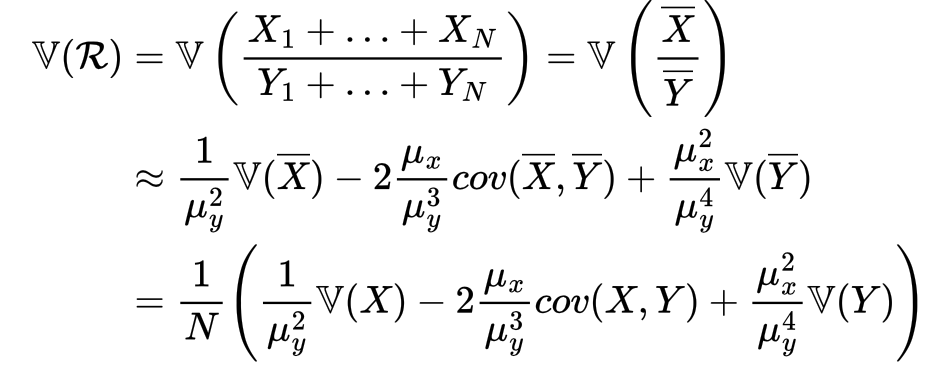

$t=\frac{\mathcal{R}_B-\mathcal{R}_A}{\sqrt{\mathbb{V}\left(\mathcal{R}_A\right)+\mathbb{V}\left(\mathcal{R}_B\right)}} \xrightarrow{N \rightarrow \inf } \mathcal{N}(0,1)$

### Перед ковариацией у нас появится тоже $\frac{1}{N}$, потому что визит на сайт и добавление товара в корзину являются **зависимыми случайными величинами**: будем предполагать, что чем больше человек посещал сайт, тем более он "прогретый" и тем больше вероятность того, что он купит товар (также если он купил товар = посетил сайт перед покупкой, тогда случайные величины 100% зависимые, без всяких предположений).

In [29]:
# Фильтрация данных для группы A
group_a = df2[df2['group'] == 'a']

# Фильтрация данных для группы B
group_b = df2[df2['group'] == 'b']

# Подсчет числа визитов для каждого пользователя в группе A
visits_a = group_a[group_a['event'] == 'shop-visit'].groupby('user_id').size().reset_index(name='visits') # Подсчет числа визитов
cart_additions_a = group_a[group_a['event'] == 'cart-add'].groupby('user_id').size().reset_index(name='cart_additions') # Подсчет числа добавлений в корзину
df_a = pd.merge(visits_a, cart_additions_a, on='user_id', how='outer')
df_a['visits'] = df_a['visits'].fillna(0)
df_a['cart_additions'] = df_a['cart_additions'].fillna(0)
df_a['visits'] += df_a['cart_additions']

# Подсчет числа визитов для каждого пользователя в группе B
visits_b = group_b[group_b['event'] == 'shop-visit'].groupby('user_id').size().reset_index(name='visits') # Подсчет числа визитов
cart_additions_b = group_b[group_b['event'] == 'cart-add'].groupby('user_id').size().reset_index(name='cart_additions') # Подсчет числа добавлений в корзину
df_b = pd.merge(visits_b, cart_additions_b, on='user_id', how='outer')
df_b['visits'] = df_b['visits'].fillna(0)
df_b['cart_additions'] = df_b['cart_additions'].fillna(0)
df_b['visits'] += df_b['cart_additions']

In [30]:
df_a.loc[df_a['user_id'] == 'NIFXUJ']

,user_id,visits,cart_additions
976,NIFXUJ,2.0,1.0


In [31]:
from scipy import stats

def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    # ИЗ ВИЗИТА В ДОБАВЛЕНИЕ В КОРЗИНУ
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)  # Длина массива а
        array_x = np.array(data["cart_additions"]) # Число добавлений в корзину для каждого пользователя
        array_y = np.array(data["visits"]) # Визиты для каждого пользователя
        mean_x, mean_y = np.mean(array_x), np.mean(array_y) # Считаем среднее
        var_x, var_y = np.var(array_x), np.var(array_y) # Считаем дисперсию
        cov_xy = np.cov(array_x, array_y)[0, 1] # считаем ковариацию между X и Y
        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x/ mean_y ** 3) * 1/n_user * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

alpha = 0.05           # допустимая вероятность ошибки I рода

pvalue = check_delta_method(df_a, df_b)
print(f'p-value теста на равенство метрик отношения: {pvalue}')

p-value теста на равенство метрик отношения: 0.002133845712948945


Мы считаем p-value и видим, что есть различие между двумя группами, на уровне значимости ошибки 5%, что говорит о том, что использование фотошопа и красивых картинок изменило конверсию пользователей.

### Задание 5 (1 балл)

Придумайте пример, в котором тест Манна-Уитни отвергает нулевую гипотезу о равенстве для распределений с равными медианами.

Постройте распределение p-value и изучите долю ошибок первого рода. Объясните, почему получился такой результат. Что тогда проверяет тест Манна-Уитни?

Статистика теста Манна-Уитни: 481600.0
p-value: 0.15419681544312153
Ошибка первого рода равна: 0.096


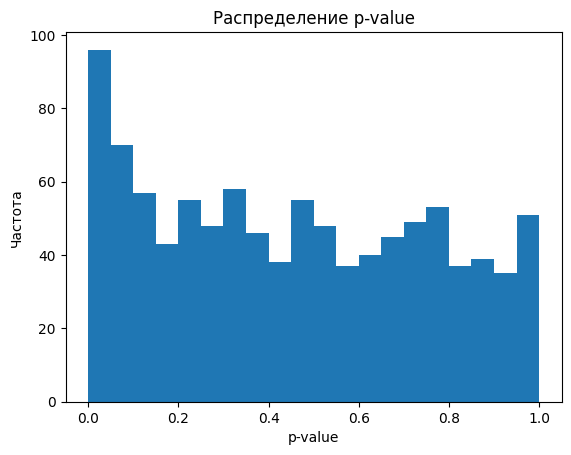

In [32]:
import numpy as np
from scipy.stats import mannwhitneyu

# Генерируем выборки
np.random.seed(42)
sample_size = 1000

sample1 = stats.uniform(loc=-1, scale=2).rvs(sample_size)
sample2 = stats.uniform(loc=-50, scale=100).rvs(sample_size)  # draw 1000 samples

# Выполняем тест Манна-Уитни
statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')

# Выводим результаты
print(f"Статистика теста Манна-Уитни: {statistic}")
print(f"p-value: {p_value}")

# Построим гистограммы распределения p-value
import matplotlib.pyplot as plt

p_values = []
for _ in range(1000):
    sample1 = stats.uniform(loc=-1, scale=2).rvs(sample_size)
    sample2 = stats.uniform(loc=-100, scale=200).rvs(sample_size)  # draw 1000 samples
    _, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    p_values.append(p_value)

print(f'Ошибка первого рода равна: {np.sum(np.array(p_values) < alpha)/len(p_values)}')

plt.hist(p_values, bins=20)
plt.title('Распределение p-value')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.show()

In [33]:
from scipy.stats import kstest, uniform

def is_uniform(sample, significance_level):
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(sample, uniform.cdf)

    return p_value

significance_level = 0.05
# Example usage
p_value = is_uniform(p_values, significance_level)

if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value

Not Uniform


7.111003109332467e-06

Мы видим, что нулевая гипотеза отвергается на уровне значимости 5%, p-value распределен неравномерно, хотя похож на равномерное распределение, а доля ошибок первого рода больше 5% уровня значимости, что означает, что нулевая гипотеза отвергается в пользу альтернативной для этих двух распределений, хотя мы знаем, что медианы и матожидания у распределений двух равномерных распределений из проведенного теста одинаковы (Мы взяли равномерное распределение $U~[-1;1]$ и $U~[-100;100]$. Это значит, что под капотом Манна-Уитни лежит вовсе не гипотеза о равенстве медиан, а гипотеза о равенстве распределений, для этого проведем другой тест, взяв уже одинаковые распределения:

Статистика теста Манна-Уитни: 483550.0
p-value: 0.20271503318238437
Ошибка первого рода равна: 0.05


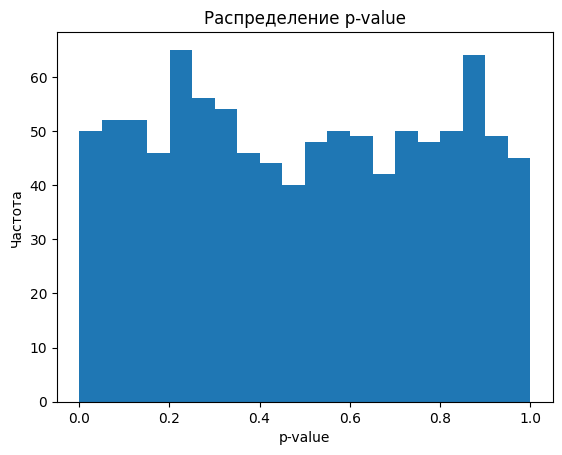

In [34]:
# Генерируем выборки
np.random.seed(42)
sample_size = 1000

sample1 = stats.uniform(loc=-1, scale=2).rvs(sample_size)
sample2 = stats.uniform(loc=-1, scale=2).rvs(sample_size)  # draw 1000 samples

# Выполняем тест Манна-Уитни
statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')

# Выводим результаты
print(f"Статистика теста Манна-Уитни: {statistic}")
print(f"p-value: {p_value}")

# Построим гистограммы распределения p-value
import matplotlib.pyplot as plt

p_values = []
for _ in range(1000):
    sample1 = stats.uniform(loc=-1, scale=2).rvs(sample_size)
    sample2 = stats.uniform(loc=-1, scale=2).rvs(sample_size)  # draw 1000 samples
    _, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    p_values.append(p_value)

print(f'Ошибка первого рода равна: {np.sum(np.array(p_values) < alpha)/len(p_values)}')

plt.hist(p_values, bins=20)
plt.title('Распределение p-value')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.show()

Вот, теперь ошибка первого рода равна 5%, p-value больше требуемого уровня значимости, что говорит о том, что нулевая гипотеза о равенстве распределений не отвергается на 5% уровне значимости, p-value распределен равномерно. Наши предположения о том, какая нулевая гипотеза используется под капотом теста Манна-Уитни подтверждается.

### Задание 6 (1.5 балл)

Вернемся к метрике revenue per user. Вам даны две очень похожие группы (файл `aa_test_logs.pkl`).

1. Постройте распределение p-value для теста на равенство средних между группами.
2. Найдите, на каком уровне искусственно добавленного эффекта средняя выручка в группах станет различима. Ошибку первого рода считайте заданной и равной 0.05. Постройте график зависимости эффекта и ошибки 2 рода.

#### То есть надо изобразить p-value на равенство средних между группами, выяснить, на каком уровне effect средняя выручка станет различима, построить зависимость $\beta$ и $\varepsilon$

In [35]:
# Прямая ссылка на скачивание файла
url = 'https://drive.google.com/uc?id=1jJSRM0LLr-U3QDH954PcTqTr4lRpyZFY'

# Загрузка файла
response = requests.get(url)

# Чтение данных pickle
df3 = pickle.loads(response.content)

In [36]:
# df3.fillna(0, inplace=True)
df3.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,DK452H,2023-12-23,first-visited,NaN,NaN,NaN,NaN,NaN
1,ED5SC3,2023-12-19,first-visited,NaN,NaN,NaN,NaN,NaN
2,ED5SC3,2023-12-29,shop-visit,second,npdt49xc6xb1fcbmlh0t,NaN,NaN,NaN
3,GD3FMD,2023-12-02,first-visited,NaN,NaN,NaN,NaN,NaN
4,GD3FMD,2023-12-02,shop-visit,second,kqsakfrjq5ys6kb0s8d0,NaN,NaN,NaN


In [ ]:
# Разобьем на тест и контроль
df3_test = df3[df3['group']=='first']
df3_control = df3[df3['group']=='second']

# Найдем пользователей, которые добавили товары в корзину и еще оплатили их
rev_orders_test = find_check_pairs(df3_test)
rev_orders_control = find_check_pairs(df3_control)

# Добавим челиков, которые ничего не покупали и которых нет в списке что-то купивших челиков
df3_test_total = pd.concat([rev_orders_test, df3_test[~df3_test['user_id'].isin(rev_orders_test['user_id'])]])[['user_id', 'group', 'cart_id', 'cart_paid_id', 'revenue']]
df3_control_total = pd.concat([rev_orders_control, df3_control[~df3_control['user_id'].isin(rev_orders_control['user_id'])]])[['user_id', 'group', 'cart_id', 'cart_paid_id', 'revenue']]

In [42]:
# Посчитаем поюзерную сумму выручек
rev_first = df3_test_total.groupby('user_id')['revenue'].sum()
rev_second = df3_control_total.groupby('user_id')['revenue'].sum()
rev_first = rev_first.fillna(0, inplace = False)
rev_second = rev_second.fillna(0, inplace = False)

Теперь мы устранили зависимость между данными, проведем теперь t-test с помощью бутстрапа, потому что теперь предпосылки для проведения этого теста выполняются.

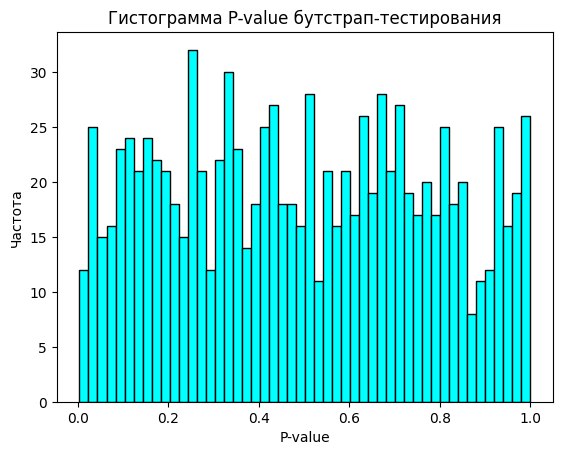

In [43]:
def bootstrap_test(a, b, n_bootstrap=10000, sample_size=None, effect=0):
    """Проводим бутстрап-тестирование, возвращаем список p-value."""

    pvalues = []
    for _ in range(n_bootstrap):
        a_sample = np.random.choice(a, size=sample_size, replace=True)
        b_with_effect = b + effect
        b_sample = np.random.choice(b_with_effect, size=sample_size, replace=True)
        t_stat, pvalue = stats.ttest_ind(a_sample, b_sample)
        pvalues.append(pvalue)

    return np.array(pvalues)

# Пример использования функции
pvalues_bootstrap = bootstrap_test(rev_first, rev_second, n_bootstrap=1000, sample_size=1000, effect=0)

# Визуализация результатов
plt.hist(pvalues_bootstrap, bins=50, color='cyan', edgecolor='black')
plt.xlabel('P-value')
plt.ylabel('Частота')
plt.title('Гистограмма P-value бутстрап-тестирования')
plt.show()


In [44]:
from scipy.stats import kstest, uniform

def is_uniform(sample, significance_level):
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(sample, uniform.cdf)

    return p_value

significance_level = 0.05
# Example usage
p_value = is_uniform(pvalues_bootstrap.flatten(), significance_level)

if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value

Uniform


0.3581938638877128

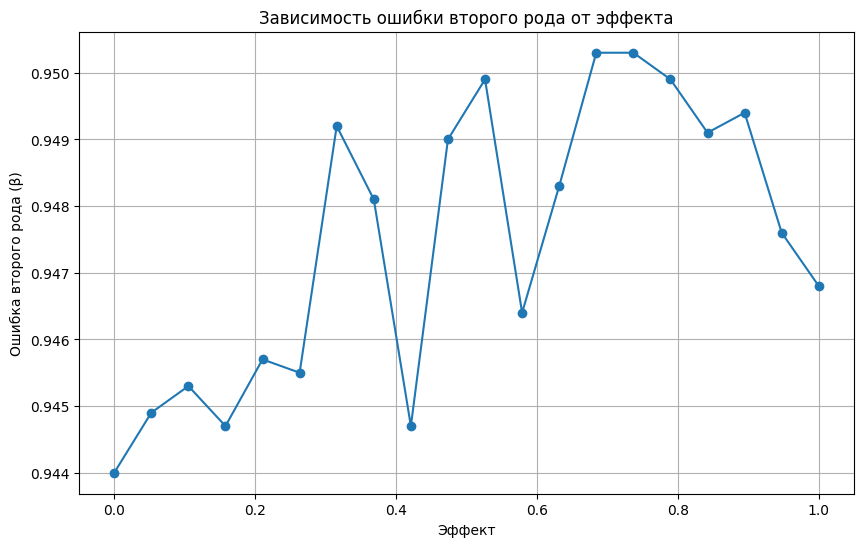

In [50]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def calculate_power(a, b, effect, alpha=0.05, n_bootstrap=10000, sample_size=None):
    """Рассчитываем мощность теста для заданного эффекта."""
    if sample_size is None:
        sample_size = min(len(a), len(b))

    n_reject = 0 # счетчик для подсчета числа отклонений от нулевой гипотезы
    for _ in range(n_bootstrap):
        a_sample = np.random.choice(a, size=sample_size, replace=True)
        b_with_effect = b + effect
        b_sample = np.random.choice(b_with_effect, size=sample_size, replace=True)
        t_stat, pvalue = stats.ttest_ind(a_sample, b_sample)
        if pvalue < alpha: # если нулевая гипотеза отвергается в пользу альтернативной (ищем, в скольких случаях мы отвергли нулевую гипотезу о равенстве средних, при том что они реально разные - мощность считаем)
            n_reject += 1

    power = n_reject / n_bootstrap
    return power

effects = np.linspace(0, 1, 20)
powers = [calculate_power(rev_first, rev_second, eff) for eff in effects]
beta = 1 - np.array(powers)


plt.figure(figsize=(10, 6))
plt.plot(effects, beta, marker='o')
plt.title('Зависимость ошибки второго рода от эффекта')
plt.xlabel('Эффект')
plt.ylabel('Ошибка второго рода (β)')
plt.grid(True)
plt.show()

Видим, что чем большее значение эффекта, тем больше ошибка второго рода, но график сильно волатильный.
По идее, чем больше эффект, тем меньше должна быть ошибка второго рода, потому что разница между группами будет больше с ростом эффекта и вероятность сказать, что они не отличаются (при том, что они по факту отличаются) должна стать меньше. То есть в идеале получить убывающий график, наверное.

### Задание 7 (1.5 балл)

На метрике revenue per user для разных групп (файл `ab_test_logs.pkl`) посчитайте мощность t-теста, бутстрапа и критерия Манна-Уитни при разных ошибках первого рода. Постройте график зависимости мощности от О1Р.

Какой тест получился мощнее остальных на уровне значимости 5%?

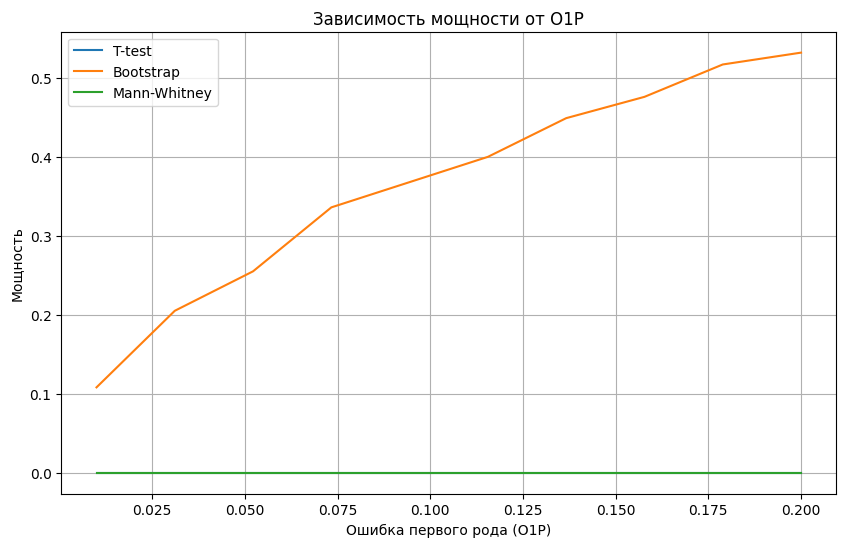

Мощность t-теста: 0.0
Мощность бутстрапа: 0.27
Мощность Манна-Уитни: 0.0
Самый мощный тест:
Bootstrap


In [51]:
def calculate_power(rev_control, rev_test, alpha, n_iter=1000, bootstrap=False, ttest=False, mann=False, sample_size=1000):
    power = 0
    for _ in range(n_iter):
        if bootstrap:
            a_sample = np.random.choice(rev_control, size=sample_size, replace=True)
            b_sample = np.random.choice(rev_test, size=sample_size, replace=True)
            _, p_value = stats.ttest_ind(a_sample, b_sample)
            if p_value < alpha:
                power += 1
        elif ttest:
            _, p_value = stats.ttest_ind(rev_first, rev_second)
            if p_value < alpha:
                power += 1
        else:
            _, p_value = stats.mannwhitneyu(rev_first, rev_second)
            if p_value < alpha:
                power += 1
    return power / n_iter

alphas = np.linspace(0.01, 0.2, 10)

powers_ttest = [calculate_power(rev_control, rev_test, alpha, ttest=True) for alpha in alphas]
powers_bootstrap = [calculate_power(rev_control, rev_test, alpha, bootstrap=True, sample_size=1000, n_iter=1000) for alpha in alphas]
powers_mannwhitney = [calculate_power(rev_control, rev_test, alpha, mann=True) for alpha in alphas]

plt.figure(figsize=(10, 6))
plt.plot(alphas, powers_ttest, label='T-test')
plt.plot(alphas, powers_bootstrap, label='Bootstrap')
plt.plot(alphas, powers_mannwhitney, label='Mann-Whitney')
plt.legend()
plt.xlabel('Ошибка первого рода (О1Р)')
plt.ylabel('Мощность')
plt.title('Зависимость мощности от О1Р')
plt.grid()
plt.show()

alpha = 0.05
ttest = calculate_power(rev_control, rev_test, alpha, ttest=True)
bootstrap = calculate_power(rev_control, rev_test, alpha, bootstrap=True, sample_size=1000, n_iter=1000)
mannwhitney = calculate_power(rev_control, rev_test, alpha, mann=True)

print(f"Мощность t-теста: {ttest}")
print(f"Мощность бутстрапа: {bootstrap}")
print(f"Мощность Манна-Уитни: {mannwhitney}")

most_powerful = max(ttest, bootstrap, mannwhitney)
print("Самый мощный тест:")
if most_powerful == ttest:
    print("T-test")
elif most_powerful == bootstrap:
    print("Bootstrap")
else:
    print("Mann-Whitney U")


Наиболее мощный тест в нашем случае получился бутстрап. Возможно это связано со свойствами бутстрапа, при большом числе итераций мы получаем несмещенную оценку. Ну или все намного проще - я просто облажался :(

### Задание 8 (2 балла)

На данных `aa_test_logs.pkl` реализуйте А/А тесты через бутстрап и постройте распределение p-value. Какое распределение у вас получилось? Почему? Попробуйте доказать этот факт

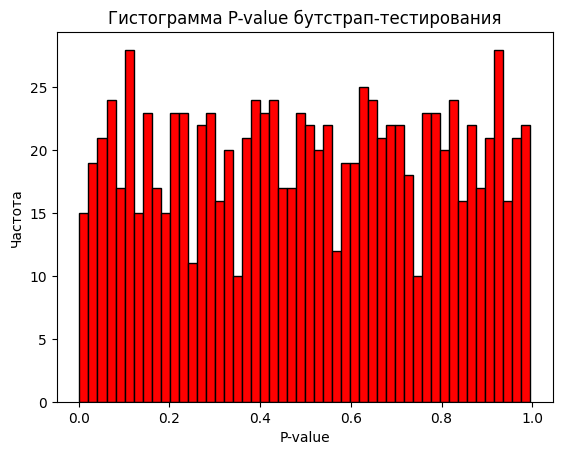

In [33]:
import matplotlib.pyplot as plt

def bootstrap_test(a, b, n_bootstrap=10000, sample_size=None, effect=0):
    """Проводим бутстрап-тестирование, возвращаем список p-value."""
    pvalues = []
    for _ in range(n_bootstrap):
        a_sample = np.random.choice(a, size=sample_size, replace=True)
        b_with_effect = b + effect
        b_sample = np.random.choice(b_with_effect, size=sample_size, replace=True)
        t_stat, pvalue = stats.ttest_ind(a_sample, b_sample)
        pvalues.append(pvalue)

    return np.array(pvalues)

# Пример использования функции
pvalues_bootstrap = bootstrap_test(rev_first, rev_second, n_bootstrap=1000, sample_size=1000, effect=0)

# Визуализация результатов
plt.hist(pvalues_bootstrap, bins=50, color='red', edgecolor='black')
plt.xlabel('P-value')
plt.ylabel('Частота')
plt.title('Гистограмма P-value бутстрап-тестирования')
plt.show()


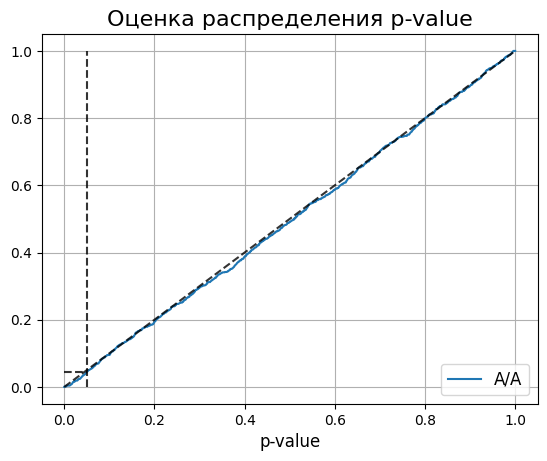

In [34]:

def plot_pvalue_distribution(pvalues_aa, alpha, beta):
    """Рисует графики распределения p-value."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    y_one = estimated_first_type_error
    X = np.linspace(0, 1, 1000)
    Y_aa = [np.mean(pvalues_aa < x) for x in X]

    plt.plot(X, Y_aa, label='A/A')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, alpha], [y_one, y_one], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)

    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

plot_pvalue_distribution(pvalues_bootstrap, alpha, beta)

Распределение p-value получилось равномерным, потому что мы использовали бутстрап, который при большом числе итераций выдает несмещенную оценку статистики. Как раз графики подтверждают это: распределение получилось равномерным и график проходит вдоль биссектрисы I координатного угла, а точка, соответствующая О1Р также лежит на этой прямой, значит критерий корректный